<a href="https://colab.research.google.com/github/riya0999/CODSOFT/blob/main/Movie_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload tmdb_5000_movies.csv.zip


Saving tmdb_5000_movies.csv.zip to tmdb_5000_movies.csv (2).zip
Saving tmdb_5000_credits.csv.zip to tmdb_5000_credits.csv (2).zip
Upload tmdb_5000_credits.csv.zip


Saving tmdb_5000_movies.csv.zip to tmdb_5000_movies.csv (3).zip
Saving tmdb_5000_credits.csv.zip to tmdb_5000_credits.csv (3).zip
Root Mean Squared Error: 0.94
R² Score: 0.32


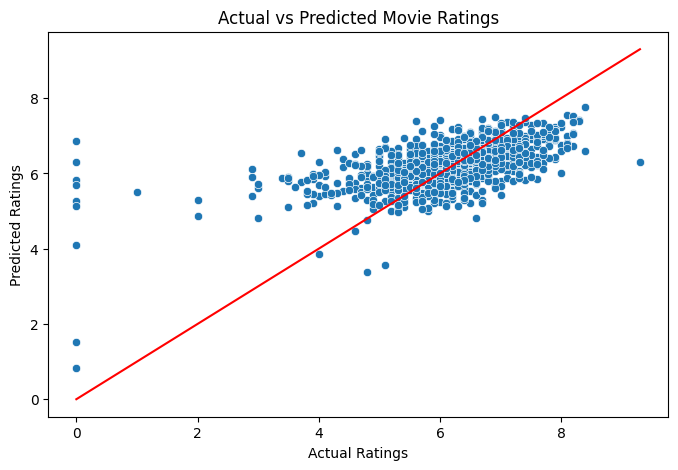

Model saved as movie_rating_model.pkl


In [4]:
# Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import zipfile
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Upload the zipped files
print("Upload tmdb_5000_movies.csv.zip")
uploaded = files.upload()

print("Upload tmdb_5000_credits.csv.zip")
uploaded = files.upload()

# Extract the ZIP files
with zipfile.ZipFile("/content/tmdb_5000_movies.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

with zipfile.ZipFile("/content/tmdb_5000_credits.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load the extracted CSV files
movies_df = pd.read_csv("/content/tmdb_5000_movies.csv")
credits_df = pd.read_csv("/content/tmdb_5000_credits.csv")

# Merge datasets on title
df = movies_df.merge(credits_df, on='title')

# Extract genres
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)] if pd.notnull(x) else [])

# Extract top 3 actors
df['actors'] = df['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)[:3]] if pd.notnull(x) else [])

# Extract director from crew
def get_director(crew_str):
    try:
        crew_list = ast.literal_eval(crew_str)
        for person in crew_list:
            if person['job'] == 'Director':
                return person['name']
    except:
        return np.nan

df['director'] = df['crew'].apply(get_director)

# Drop rows with missing target (vote_average)
df.dropna(subset=['vote_average'], inplace=True)

# Fill missing values
df['budget'].fillna(df['budget'].median(), inplace=True)
df['runtime'].fillna(df['runtime'].median(), inplace=True)

# One-hot encode genres and actors
df['actors'] = df['actors'].apply(lambda x: x if isinstance(x, list) else [])
df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])

mlb_genre = MultiLabelBinarizer()
mlb_actors = MultiLabelBinarizer()

genre_encoded = mlb_genre.fit_transform(df['genres'])
actors_encoded = mlb_actors.fit_transform(df['actors'])

genre_df = pd.DataFrame(genre_encoded, columns=["Genre_" + g for g in mlb_genre.classes_])
actors_df = pd.DataFrame(actors_encoded, columns=["Actor_" + a for a in mlb_actors.classes_])

# One-hot encode top 20 directors
df['director'] = df['director'].astype(str)
top_directors = df['director'].value_counts().nlargest(20).index
df['director'] = df['director'].apply(lambda x: x if x in top_directors else 'Other')
director_encoded = pd.get_dummies(df['director'], prefix='Director')

# Combine all features into a final DataFrame
df_final = pd.concat([df[['budget', 'runtime', 'release_date']], genre_df, actors_df, director_encoded], axis=1)

# Extract release year
df_final['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df_final['year'] = df_final['release_date'].dt.year
df_final.drop(columns=['release_date'], inplace=True)

# Define target variable
target = df['vote_average']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_final, target, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", round(rmse, 2))
print("R² Score:", round(r2, 2))

# Plot actual vs predicted ratings
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Movie Ratings")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

# Save the model
joblib.dump(model, '/content/movie_rating_model.pkl')
print("Model saved as movie_rating_model.pkl")
